<a href="https://colab.research.google.com/github/augnoel/noel/blob/develop/standardA_clustering_prac6_ipynb%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##0. 패키지 호출

In [1]:
#클러스터링 분석에 사용할 기본 패키지 호출
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta

from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering, KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

In [2]:
#warning 메시지 무시를 위한 코드
import warnings
warnings.filterwarnings('ignore')

In [3]:
#Google Drive 마운트
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##1. 데이터 탐색

In [6]:
#데이터셋 출처 - https://www.kaggle.com/datasets/imakash3011/customer-personality-analysis
df_customer = pd.read_csv("/content/drive/MyDrive/marketing_campaign.csv", delimiter = "\t")
df_customer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

In [7]:
df_customer.head()
# ID 칼럼의 필요성

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


In [8]:
print(df_customer['ID'].nunique())
# 분석할때 ID 지워도 영향이 없을 것으로 판단

2240


### 1.1 데이터 전처리

In [9]:
#결측치 제거
df_customer.isna().sum()
# 클러스터링 할때 거리나 밀도를 기반으로 함
# 데이터 포인트 간 데이터 계산 여부가 중요
# 범주형 데이터는 좋지 않음
# 댜부분의 클러스터링은 유클리디안 거리 기반이기 때문
# 차원이 증가할 수록 데이터 간의 거리 원근 판단이 어려워짐
# 카테고리컬 변수는 줄여주는 거이 좋음
# 시간, 년도에 대한 것도 클러스터링에 안 좋음 >> 거리 계산 할 수 있는 칼럼으로 바꾸기

# !% 정도의 결측치.

ID                      0
Year_Birth              0
Education               0
Marital_Status          0
Income                 24
Kidhome                 0
Teenhome                0
Dt_Customer             0
Recency                 0
MntWines                0
MntFruits               0
MntMeatProducts         0
MntFishProducts         0
MntSweetProducts        0
MntGoldProds            0
NumDealsPurchases       0
NumWebPurchases         0
NumCatalogPurchases     0
NumStorePurchases       0
NumWebVisitsMonth       0
AcceptedCmp3            0
AcceptedCmp4            0
AcceptedCmp5            0
AcceptedCmp1            0
AcceptedCmp2            0
Complain                0
Z_CostContact           0
Z_Revenue               0
Response                0
dtype: int64

In [11]:
df_customer['Income'] = df_customer['Income'].fillna(0)
# 결측치를 0으로 채움

In [12]:
#날짜 데이터
# 스케일링 가능한 단위로 바꾸는 과정

#1. Year_Birth -> 나이
df_customer['Age'] = 2024 - df_customer['Year_Birth']

#2. Dt_Customer -> 가입 기간(개월)
# 년도로 해도 됨
# format으로 DF의 데이터 형태 지정
def get_months(dt_str, format = '%d-%m-%Y'):
  # 오늘 날짜를 기준
  dt_now = datetime.now()
  # 스트링을 datetime으로 바꾸는 함수 - strptime
  dt_origin = datetime.strptime(dt_str, format)
  # relativedelta :
  delta = relativedelta(dt_now, dt_origin)
  # 년도 차이에 12개월 곱하면 개월 차이가 남
  return delta.months + (delta.years * 12)

df_customer['month_customer'] = df_customer['Dt_Customer'].apply(get_months)

In [13]:
df_customer.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response,Age,month_customer
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,0,0,0,0,0,3,11,1,67,139
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,0,0,0,0,0,3,11,0,70,121
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,0,0,0,0,0,3,11,0,59,127
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,0,0,0,0,0,3,11,0,40,121
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,0,0,0,0,0,3,11,0,43,122


In [14]:
#범주형 변수
# 범주형 변수가 많으면 원핫인코딩하면 차원이 커져서 클러스터링에 좋지 않음


#1. Education 학력칼럼
df_customer['Education'].value_counts()
# 5가지 항목이 있음
# master랑 2ncycle을 합쳐도 될것 같음

Education
Graduation    1127
PhD            486
Master         370
2n Cycle       203
Basic           54
Name: count, dtype: int64

In [15]:
#2n Cycle <- Master 수행 중인 것으로 간주하여 Master로 합침 (차원 축소)
# 칼럼을 돌면서 apply 함수 적용
#if문에 해당하면 master 출력, 그렇지않으면 x 출력
df_customer['Education'] = df_customer['Education'].apply(lambda x : "Master" if x == "2n Cycle" else x)

In [16]:
# 2n_cycle >>master로 변경됐는지 확인
df_customer['Education'].value_counts()

Education
Graduation    1127
Master         573
PhD            486
Basic           54
Name: count, dtype: int64

In [17]:
#2. Marital_Status 결혼상태
# 결혼상태 vs 솔로인 경우로 통패합
df_customer['Marital_Status'].value_counts()

Marital_Status
Married     864
Together    580
Single      480
Divorced    232
Widow        77
Alone         3
Absurd        2
YOLO          2
Name: count, dtype: int64

In [18]:
#["Married", "Together"] => Together / 나머지는 Alone
# x가 []범주 안에 있으면 together 출력, 그렇 않으면 alone
df_customer['Marital_Status'] = df_customer['Marital_Status'].apply(lambda x : "Together" if x in ["Married", "Together"] else "Alone")

In [19]:
df_customer['Marital_Status'].value_counts()

Marital_Status
Together    1444
Alone        796
Name: count, dtype: int64

In [22]:
# Feature Generation - 가구 구성 수
#family size 추가

family_size = []
# itertuples : DF에 잇는 모든 내용을 한번씩 가져오면서 for 문 실행, 속도가 빠름 / 각 속성이 이름이 있으면 namedtuple.
# iterrows : 위와 비슷
for row in df_customer.itertuples(index = False):
  num_family = 1 if row.Marital_Status == "Alone" else 2
  # namedtuple 이면서 .이름으로 항목 불러올 수 있음
  num_family = num_family + row.Kidhome + row.Teenhome

  family_size.append(num_family)

df_customer['Familyhome'] = family_size

In [24]:
#One hot encoidng + 불필요한 컬럼 제거
# get_dummies : 새로운 DF
df_customer_anal = pd.concat([df_customer, pd.get_dummies(df_customer['Education'], prefix="Edu", dtype=int),
                              pd.get_dummies(df_customer['Marital_Status'], prefix="Status", dtype=int)], axis=1)
# 지워줘야할 칼럼
col_drop = ['ID', 'Year_Birth', 'Dt_Customer', 'Kidhome', 'Teenhome', 'Education', 'Marital_Status',
            'Z_CostContact', 'Z_Revenue']   # 쓸모없는 상수도 지움
df_customer_anal = df_customer_anal.drop(col_drop, axis=1)

In [25]:
df_customer_anal
# 인컴이 너무 큼

,Income,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,...,Response,Age,month_customer,Familyhome,Edu_Basic,Edu_Graduation,Edu_Master,Edu_PhD,Status_Alone,Status_Together
0,58138.0,58,635,88,546,172,88,88,3,8,...,1,67,139,1,0,1,0,0,1,0
1,46344.0,38,11,1,6,2,1,6,2,1,...,0,70,121,3,0,1,0,0,1,0
2,71613.0,26,426,49,127,111,21,42,1,8,...,0,59,127,2,0,1,0,0,0,1
3,26646.0,26,11,4,20,10,3,5,2,2,...,0,40,121,3,0,1,0,0,0,1
4,58293.0,94,173,43,118,46,27,15,5,5,...,0,43,122,3,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,61223.0,46,709,43,182,42,118,247,2,9,...,0,57,129,3,0,1,0,0,0,1
2236,64014.0,56,406,0,30,0,0,8,7,8,...,0,78,117,5,0,0,0,1,0,1
2237,56981.0,91,908,48,217,32,12,24,1,2,...,0,43,122,1,0,1,0,0,1,0
2238,69245.0,8,428,30,214,80,30,61,2,6,...,0,68,122,3,0,0,1,0,0,1


In [26]:
scaler = StandardScaler()
# 인컴을 줄이기 위해 스탠다드스케일러 진행
df_customer_anal = pd.DataFrame(scaler.fit_transform(df_customer_anal), columns=df_customer_anal.columns)

In [27]:
df_customer_anal.head()

,Income,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,...,Response,Age,month_customer,Familyhome,Edu_Basic,Edu_Graduation,Edu_Master,Edu_PhD,Status_Alone,Status_Together
0,0.251939,0.307039,0.983781,1.551577,1.679702,2.462147,1.476500,0.843207,0.349414,1.409304,...,2.388846,0.985345,1.579732,-1.759115,-0.157171,0.993769,-0.586286,-0.526385,1.346874,-1.346874
1,-0.208699,-0.383664,-0.870479,-0.636301,-0.713225,-0.650449,-0.631503,-0.729006,-0.168236,-1.110409,...,-0.418612,1.235733,-1.124700,0.446548,-0.157171,0.993769,-0.586286,-0.526385,1.346874,-1.346874
2,0.778231,-0.798086,0.362723,0.570804,-0.177032,1.345274,-0.146905,-0.038766,-0.685887,1.409304,...,-0.418612,0.317643,-0.223223,-0.656283,-0.157171,0.993769,-0.586286,-0.526385,-0.742460,0.742460
3,-0.978043,-0.798086,-0.870479,-0.560857,-0.651187,-0.503974,-0.583043,-0.748179,-0.168236,-0.750450,...,-0.418612,-1.268149,-1.124700,0.446548,-0.157171,0.993769,-0.586286,-0.526385,-0.742460,0.742460
4,0.257992,1.550305,-0.389085,0.419916,-0.216914,0.155164,-0.001525,-0.556446,1.384715,0.329427,...,-0.418612,-1.017761,-0.974454,0.446548,-0.157171,-1.006270,-0.586286,1.899751,-0.742460,0.742460


## 2. 클러스터링 분석

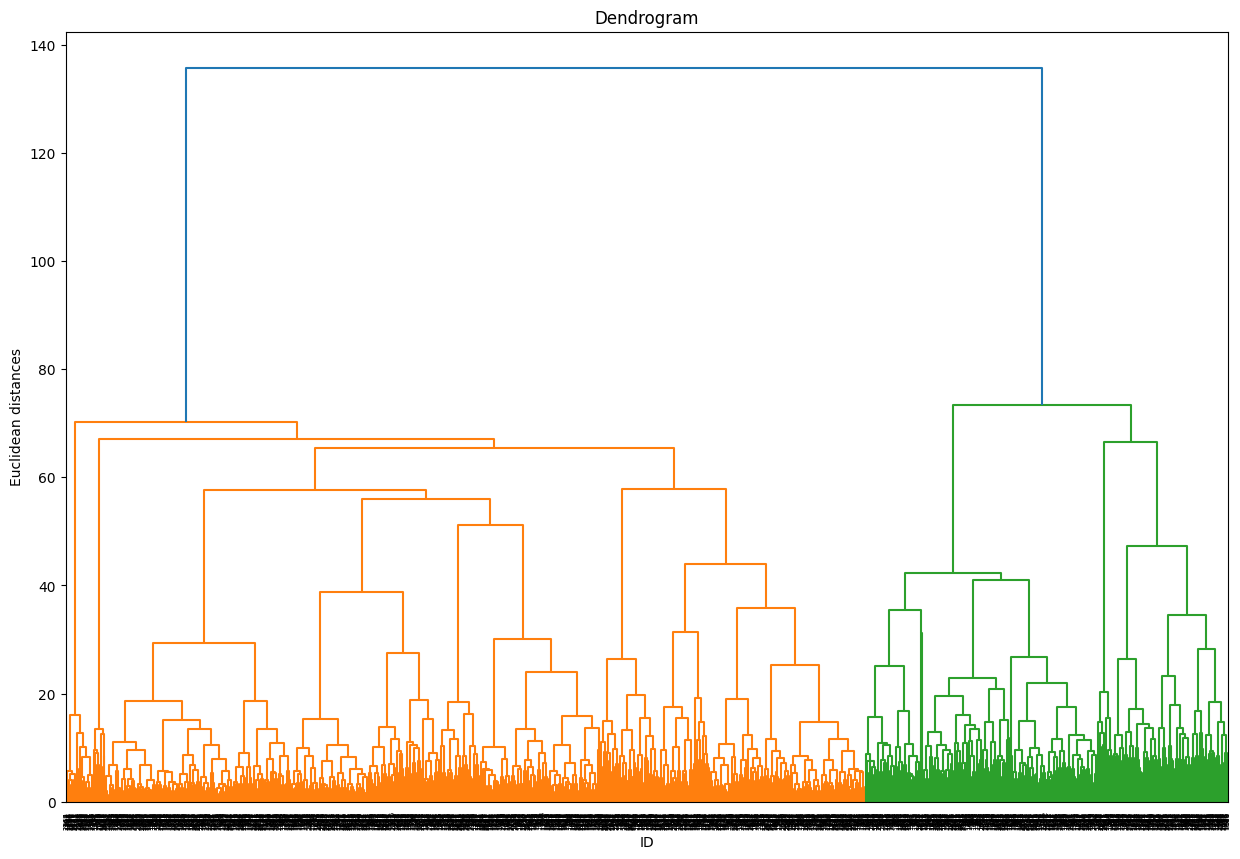

In [28]:
#덴드로그램 작성
#https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.dendrogram.html
# 차원이 크기때문에 밀도를 논하기 힘듬
# 차원이 늘어날 수록 거리가 증가하기 때문에 밀도가 커짐

plt.figure(figsize=(15,10))
plt.title('Dendrogram')
plt.xlabel('ID')
plt.ylabel('Euclidean distances')
dgram = dendrogram(linkage(df_customer_anal, method = 'ward'))
plt.show()
#

In [29]:
# 적절한 k찾기
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=9).fit(df_customer_anal)
    silhouette_avg = silhouette_score(df_customer_anal, kmeans.labels_)
    print("k = {} -> silhouette index {}".format(k, silhouette_avg))
    # k가 2일때 가장 큼 0.20라 좋지는 않음

k = 2 -> silhouette index 0.20616628331553036
k = 3 -> silhouette index 0.10624297341240144
k = 4 -> silhouette index 0.09940109641758506
k = 5 -> silhouette index 0.11117746204860249
k = 6 -> silhouette index 0.11714880516593616
k = 7 -> silhouette index 0.12655352413312448
k = 8 -> silhouette index 0.10829787624239127
k = 9 -> silhouette index 0.12462262425949347


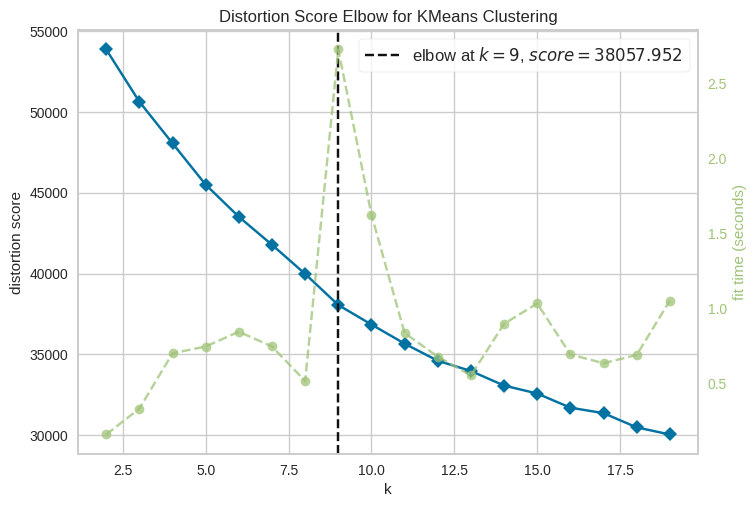

KElbowVisualizer(ax=<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>,
                 estimator=KMeans(n_clusters=19, random_state=9), k=(2, 20))

In [30]:
# 엘보포인트 그려주는 패키지
from yellowbrick.cluster.elbow import kelbow_visualizer

kelbow_visualizer(KMeans(random_state=9), df_customer_anal, k=(2,20))
#ycnr : 클러스터링 중심에서 각데이터까지의 거리 차이의 합의 제곱


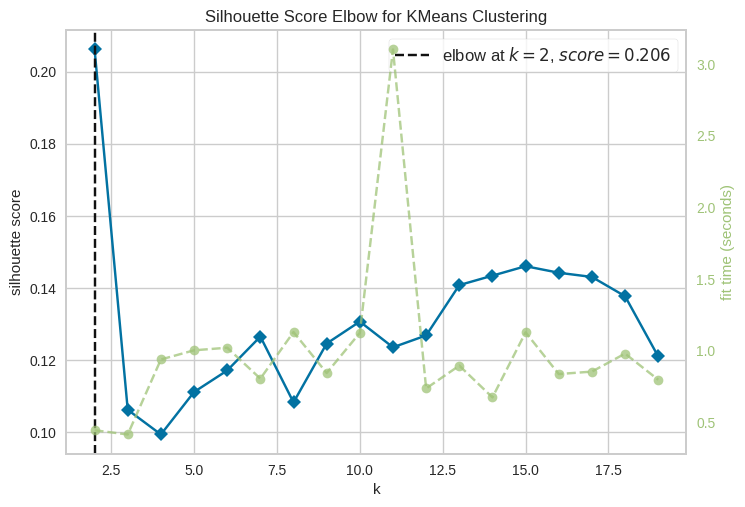

KElbowVisualizer(ax=<Axes: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>,
                 estimator=KMeans(n_clusters=19, random_state=9), k=(2, 20),
                 metric='silhouette')

In [31]:
kelbow_visualizer(KMeans(random_state=9), df_customer_anal, k=(2,20), metric="silhouette")
# 메트릭을 실루엣으로 계산

In [32]:
# 센트로이드 계산
kmeans = KMeans(n_clusters=2, random_state=9).fit(df_customer_anal)
df_centroids = pd.DataFrame(kmeans.cluster_centers_, columns=df_customer_anal.columns)
df_centroids

,Income,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,...,Response,Age,month_customer,Familyhome,Edu_Basic,Edu_Graduation,Edu_Master,Edu_PhD,Status_Alone,Status_Together
0,-0.496436,-0.015214,-0.562945,-0.491408,-0.561047,-0.505168,-0.487915,-0.396835,0.113846,-0.386057,...,-0.152107,-0.084309,-0.079618,0.350650,0.093223,-0.043932,0.041506,-0.025335,-0.041473,0.041473
1,0.796607,0.024413,0.903331,0.788539,0.900285,0.810619,0.782933,0.636782,-0.182682,0.619487,...,0.244079,0.135286,0.127759,-0.562671,-0.149590,0.070496,-0.066602,0.040654,0.066550,-0.066550


In [34]:

import plotly.graph_objects as go

def plot_radar_from_centroid(df_centroids):
  fig = go.Figure()
  categories = df_centroids.columns
  for row in df_centroids.iterrows():
    fig.add_trace(go.Scatterpolar(
        r=row[1].tolist(),
        theta=categories,
        fill='toself',
        name='cluster {}'.format(row[0])
    ))

  fig.update_layout(
      autosize=False,
      width=1000,
      height=800,
  )
  fig.show()

In [35]:
plot_radar_from_centroid(df_centroids)
#방사형 그래프
# 스케일링된 값을 이용한 것이라서 절대적이다고 판단하지 말것

In [36]:
h_clustering = AgglomerativeClustering(n_clusters = 2, affinity = 'euclidean', linkage = 'ward').fit(df_customer_anal)
h_silhouette_avg = silhouette_score(df_customer_anal, h_clustering.labels_)
k_silhouette_avg = silhouette_score(df_customer_anal, kmeans.labels_)
print("Silhouette\n* hierarchical : {}\n* kmeans : {}".format(h_silhouette_avg, k_silhouette_avg))
# 뭐가 더 좋은지
#k-means의 실루엣계수가 더 좋음
# 절대적이진 않음

Silhouette
* hierarchical : 0.19766401530569994
* kmeans : 0.20616628331553036


In [37]:
#Kmeans Centroid를 실제값으로 풀어서 클러스터별 특성 살펴보기
# 스케일링한 것을 inverse_transform하여 원래 형태로 풀어냄
df_cluster_res = pd.DataFrame(scaler.inverse_transform(df_customer_anal), columns = df_customer_anal.columns)
df_cluster_res['cluster'] = kmeans.labels_

In [38]:
df_cluster_res.head()

,Income,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,...,Age,month_customer,Familyhome,Edu_Basic,Edu_Graduation,Edu_Master,Edu_PhD,Status_Alone,Status_Together,cluster
0,58138.0,58.0,635.0,88.0,546.0,172.0,88.0,88.0,3.0,8.0,...,67.0,139.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1
1,46344.0,38.0,11.0,1.0,6.0,2.0,1.0,6.0,2.0,1.0,...,70.0,121.0,3.0,0.0,1.0,0.0,0.0,1.0,0.0,0
2,71613.0,26.0,426.0,49.0,127.0,111.0,21.0,42.0,1.0,8.0,...,59.0,127.0,2.0,0.0,1.0,0.0,0.0,0.0,1.0,1
3,26646.0,26.0,11.0,4.0,20.0,10.0,3.0,5.0,2.0,2.0,...,40.0,121.0,3.0,0.0,1.0,0.0,0.0,0.0,1.0,0
4,58293.0,94.0,173.0,43.0,118.0,46.0,27.0,15.0,5.0,5.0,...,43.0,122.0,3.0,0.0,0.0,0.0,1.0,0.0,1.0,0


In [39]:
df_cluster_res['cluster'].value_counts()
# 클러스터의 차이가 크지 않음

cluster
0    1380
1     860
Name: count, dtype: int64

In [40]:
df_cluster_summary = df_cluster_res.groupby('cluster').mean().T
df_cluster_summary
# 칼럼과 행을 바

cluster,0,1
Income,38976.886957,72083.494186
Recency,48.668841,49.816279
MntWines,114.492029,607.926744
MntFruits,6.761594,57.658140
MntMeatProducts,40.341304,370.112791
MntFishProducts,9.934783,81.798837
MntSweetProducts,6.926087,59.375581
MntGoldProds,23.324638,77.233721
NumDealsPurchases,2.544928,1.972093
NumWebPurchases,3.012319,5.805814


In [41]:
from scipy.stats import ttest_ind

p_values = {}
for column in df_cluster_res.columns[:-1]:  # 'cluster' 열은 제외
    group1 = df_cluster_res[df_cluster_res['cluster'] == 0][column]
    group2 = df_cluster_res[df_cluster_res['cluster'] == 1][column]
    t_stat, p_val = ttest_ind(group1, group2)
    p_values[column] = round(p_val, 4)
# t-test 추가
# p-value를 Series로 변환하여 출력
p_values_series = pd.Series(p_values)
df_cluster_summary['ttest'] = p_values_series
df_cluster_summary

cluster,0,1,ttest
Income,38976.886957,72083.494186,0.0000
Recency,48.668841,49.816279,0.3619
MntWines,114.492029,607.926744,0.0000
MntFruits,6.761594,57.658140,0.0000
MntMeatProducts,40.341304,370.112791,0.0000
MntFishProducts,9.934783,81.798837,0.0000
MntSweetProducts,6.926087,59.375581,0.0000
MntGoldProds,23.324638,77.233721,0.0000
NumDealsPurchases,2.544928,1.972093,0.0000
NumWebPurchases,3.012319,5.805814,0.0000


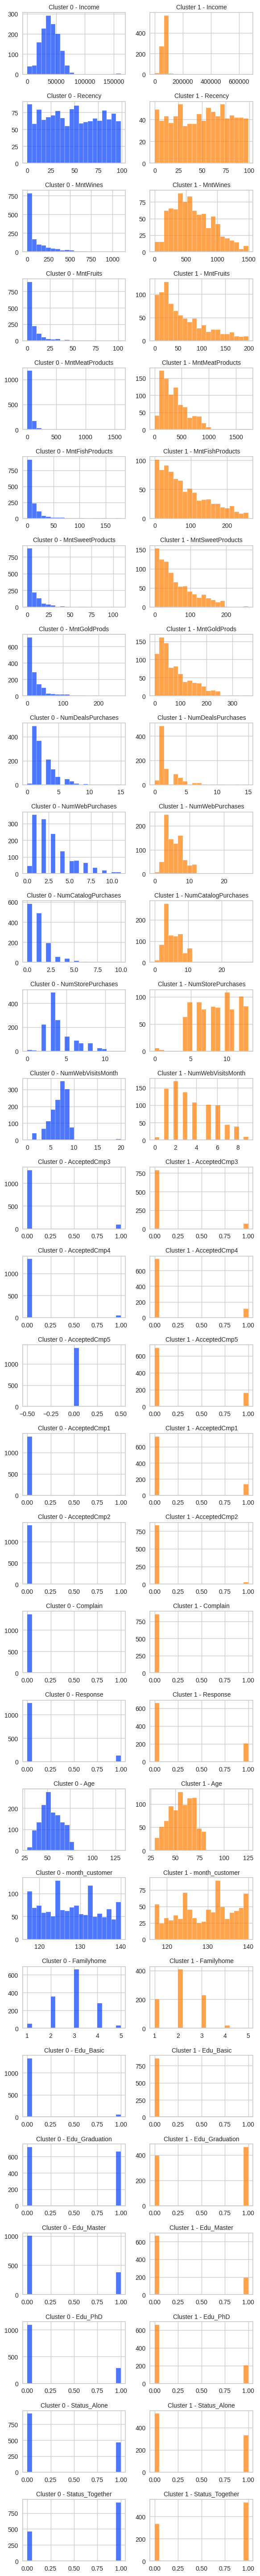

In [42]:
colors = sns.color_palette("bright")

features = df_cluster_res.columns[:-1]
clusters = df_cluster_res['cluster'].unique()
clusters.sort()

# Setting up the subplots
n_rows = len(features)
n_cols = len(clusters)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(6, 2*n_rows))

# Plotting histograms
for i, feature in enumerate(features):
    for j, cluster in enumerate(clusters):
        data = df_cluster_res[df_cluster_res['cluster'] == cluster][feature]
        axes[i, j].hist(data, bins=20, color=colors[j], edgecolor='w', alpha=0.7)
        axes[i, j].set_title(f'Cluster {cluster} - {feature}', fontsize=10)
        axes[i, j].set_xlabel('')
        axes[i, j].set_ylabel('')
# 0,1, 클러스터별로 분포된 칼럼
# Adjusting layout to prevent overlapping
plt.tight_layout()
plt.show()

In [43]:
# 시각화 결과를 이용해 -tsneplot진행
def plot_tsne_2d(df):
  tsne = TSNE(n_components=2)

  df_tsne = pd.DataFrame(data = tsne.fit_transform(df), columns = ['col1', 'col2'])
  df_tsne["label"] = df['cluster']
  # 클러스터 칼럼을 기반으로 그래프
  g = sns.FacetGrid(df_tsne, hue="label", height = 8, margin_titles = True,
                  palette = sns.color_palette())
  g.map_dataframe(plt.scatter, "col1", "col2")
  g.add_legend()
  g.fig.subplots_adjust(top=0.9)
  g.fig.suptitle("t-sne")
  g.set_xlabels("X")
  g.set_ylabels("Y")

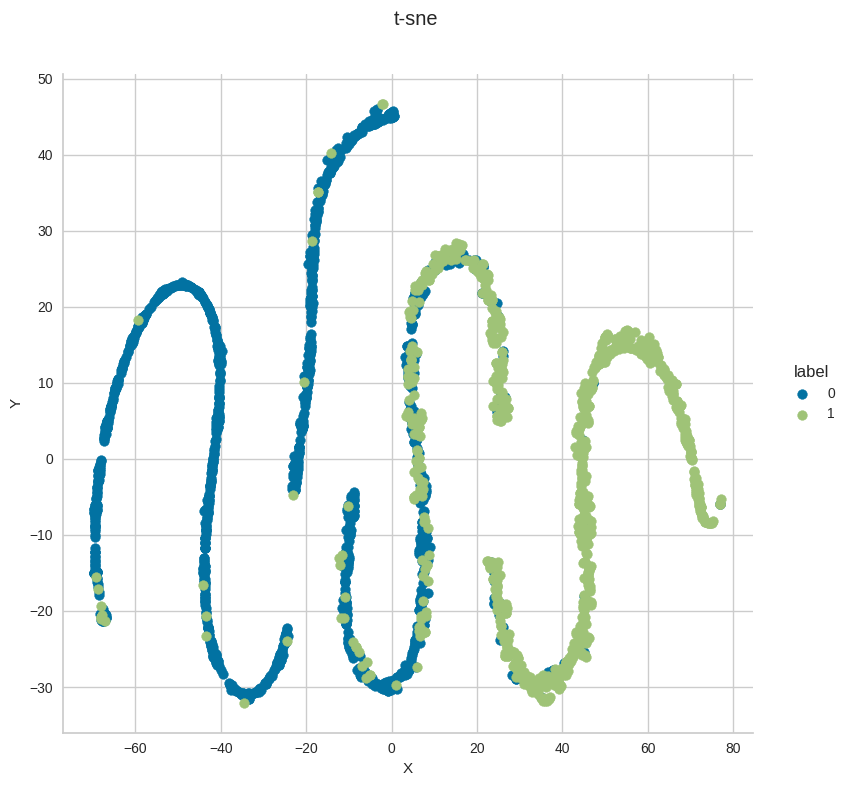

In [44]:
plot_tsne_2d(df_cluster_res)
# 30차원을 2차원으로 줄인 결과

# 클러스터를 활용한 군집을 만들고 군집의 특성 파악, 비교
# 1번 클러스터가 구매력이 높음
# 어느 채널을 통해 구매하는지 파악할 수도 있음


## 3. 클러스터링 성능을 높이기 위한 고민

In [45]:
#Feature Generation
#합칠 수 있는 컬럼을 합쳐서 차원을 축소
df_customer2 = df_customer.copy()
promotions = ['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3',
              'AcceptedCmp4', 'AcceptedCmp5', 'Response']
df_customer2['AcceptedPromo'] = df_customer2[promotions].sum(axis=1)

In [47]:
# 차원 축소
# 6개 차원을 3개로 축소
mnt = ['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']
df_mnt = df_customer2[mnt]
pca = PCA(n_components = 3)
df_mnt_pca = pd.DataFrame(data = pca.fit_transform(df_mnt), columns = ['mnt_pc1', 'mnt_pc2', 'mnt_pc3'])

In [48]:
sum(pca.explained_variance_ratio_)
# 98% 분산
# 3개만 써도 데이터의 분포를 반영한다고 판단

0.9810324189611292

In [49]:
# pca는 각 칼럼이 어떤 것을 설명하는지 알기 힘듬

pca.components_

array([[ 0.88299766,  0.05178899,  0.45365489,  0.07373121,  0.05285913,
         0.05999909],
       [-0.46689267,  0.07218054,  0.87158941,  0.10771774,  0.07018963,
         0.02456457],
       [ 0.04435503, -0.33757767,  0.17118462, -0.59896746, -0.35051025,
        -0.61086031]])

In [50]:
#신규 컬럼 활용 + 불필요한 컬럼 제거
#데이터 전처리를 한 번 더 하는 과정
# 차원 축소
col_skip = ['Age', 'Recency', 'Complain']
df_customer_anal2 = pd.concat([df_customer2, df_mnt_pca],
                               axis=1)
col_drop = ['ID', 'Year_Birth', 'Dt_Customer', 'Kidhome', 'Teenhome', 'Education', 'Marital_Status',
            'Z_CostContact', 'Z_Revenue'] + promotions + mnt + col_skip
df_customer_anal2 = df_customer_anal2.drop(col_drop, axis=1)

In [51]:
df_customer_anal2.head()

,Income,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,month_customer,Familyhome,AcceptedPromo,mnt_pc1,mnt_pc2,mnt_pc3
0,58138.0,3,8,10,4,7,139,1,1,483.256841,200.100604,-70.025325
1,46344.0,2,1,1,2,5,121,3,0,-339.265959,-11.929168,21.636101
2,71613.0,1,8,2,10,4,127,2,0,95.810035,-82.733289,-49.735579
3,26646.0,2,2,0,4,6,121,3,0,-332.123855,1.467182,18.138053
4,58293.0,5,5,3,6,5,122,3,0,-138.077350,19.869409,-7.149546


In [52]:
scaler2 = StandardScaler()
df_customer_anal2_s = pd.DataFrame(scaler2.fit_transform(df_customer_anal2), columns=df_customer_anal2.columns)

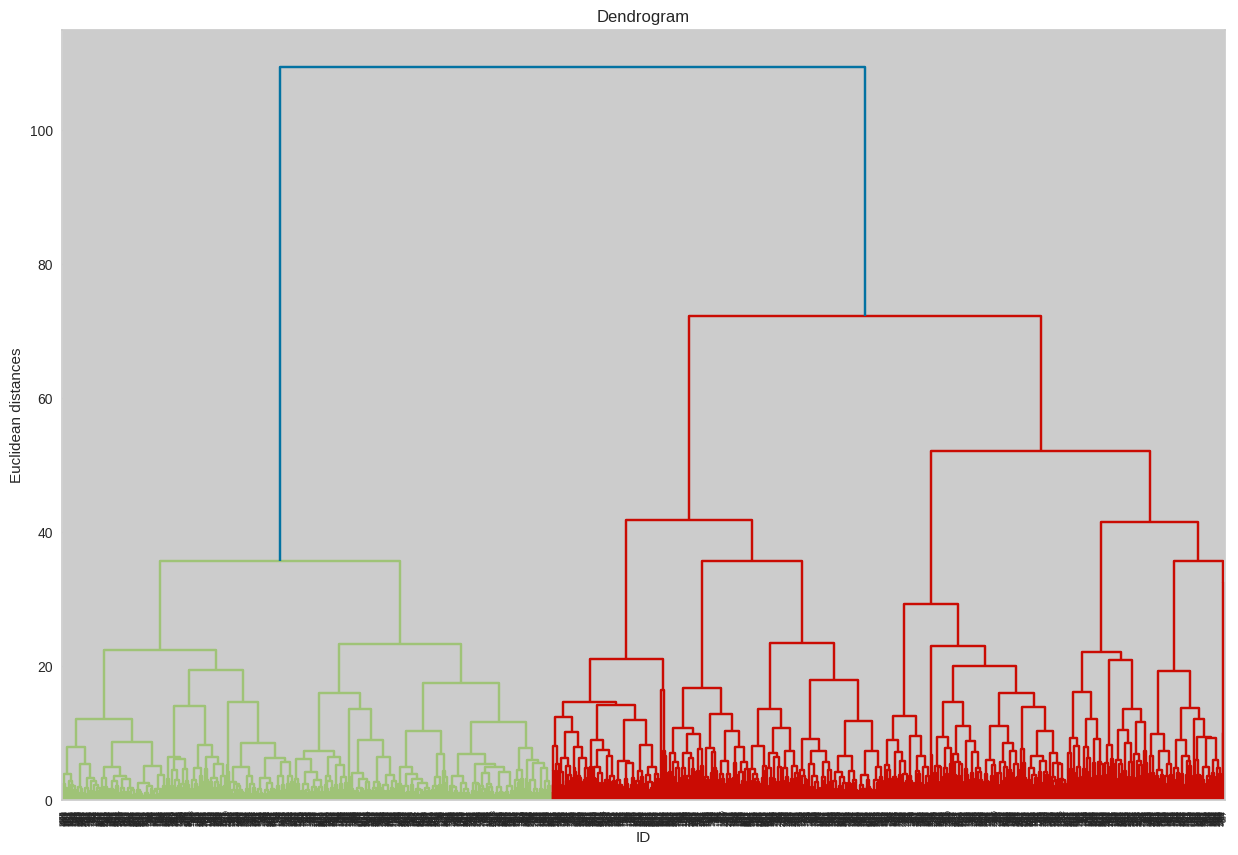

In [53]:
plt.figure(figsize=(15,10))
plt.title('Dendrogram')
plt.xlabel('ID')
plt.ylabel('Euclidean distances')
dgram = dendrogram(linkage(df_customer_anal2_s, method = 'ward'))
plt.show()

In [54]:
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=9).fit(df_customer_anal2_s)
    silhouette_avg = silhouette_score(df_customer_anal2_s, kmeans.labels_)
    print("k = {} -> silhouette index {}".format(k, silhouette_avg))

k = 2 -> silhouette index 0.2838259017400411
k = 3 -> silhouette index 0.255073158865039
k = 4 -> silhouette index 0.24737609937960303
k = 5 -> silhouette index 0.2471605731706584
k = 6 -> silhouette index 0.15501887188239405
k = 7 -> silhouette index 0.15824897640648972
k = 8 -> silhouette index 0.15998832466073443
k = 9 -> silhouette index 0.15349257985728149


In [55]:
# k 값 3으로 클러스터
h_clustering2 = AgglomerativeClustering(n_clusters = 3, affinity = 'euclidean', linkage = 'ward').fit(df_customer_anal2_s)
kmeans2 = KMeans(n_clusters=3, random_state=9).fit(df_customer_anal2_s)
h_silhouette_avg2 = silhouette_score(df_customer_anal2_s, h_clustering2.labels_)
k_silhouette_avg2 = silhouette_score(df_customer_anal2_s, kmeans2.labels_)
print("Silhouette\n* hierarchical : {}\n* kmeans : {}".format(h_silhouette_avg2, k_silhouette_avg2))

Silhouette
* hierarchical : 0.19698568848124975
* kmeans : 0.255073158865039


In [56]:
kmeans2 = KMeans(n_clusters=3, random_state=9).fit(df_customer_anal2_s)
df_centroids2 = pd.DataFrame(kmeans2.cluster_centers_, columns=df_customer_anal2_s.columns)
df_centroids2 = pd.DataFrame(scaler2.inverse_transform(df_centroids2), columns = df_centroids2.columns)
df_centroids2

,Income,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,month_customer,Familyhome,AcceptedPromo,mnt_pc1,mnt_pc2,mnt_pc3
0,34525.557237,1.972564,2.126774,0.588458,3.287606,6.363292,127.154210,2.868496,0.166509,-300.168414,-10.810401,13.409038
1,57864.488038,3.936204,6.749601,3.205742,7.794258,6.052632,131.508772,2.867624,0.446571,166.896563,-104.048643,-9.237463
2,77347.771583,1.178058,4.802158,5.991007,8.287770,2.496403,127.607914,1.767986,0.980216,382.435015,137.886859,-15.074576


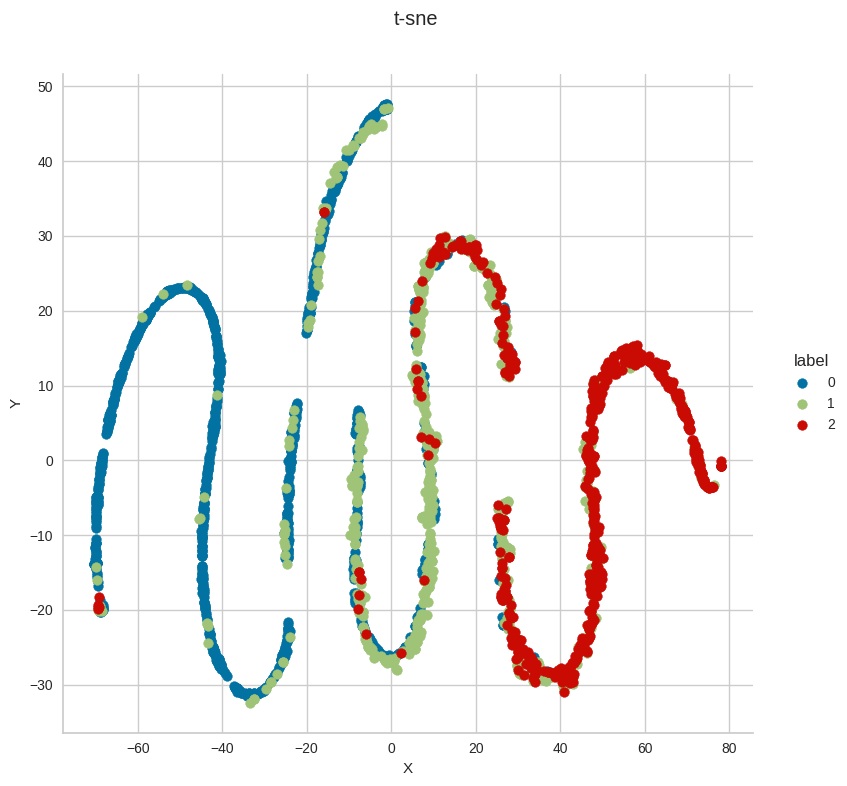

In [57]:
df_cluster_res2 = df_customer_anal2.copy()
df_cluster_res2['cluster'] = kmeans2.labels_
plot_tsne_2d(df_cluster_res2)
# tsne결과
#